C:\Users\saini\Anaconda3\envs\final_year\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


pandas.core.frame.DataFrame

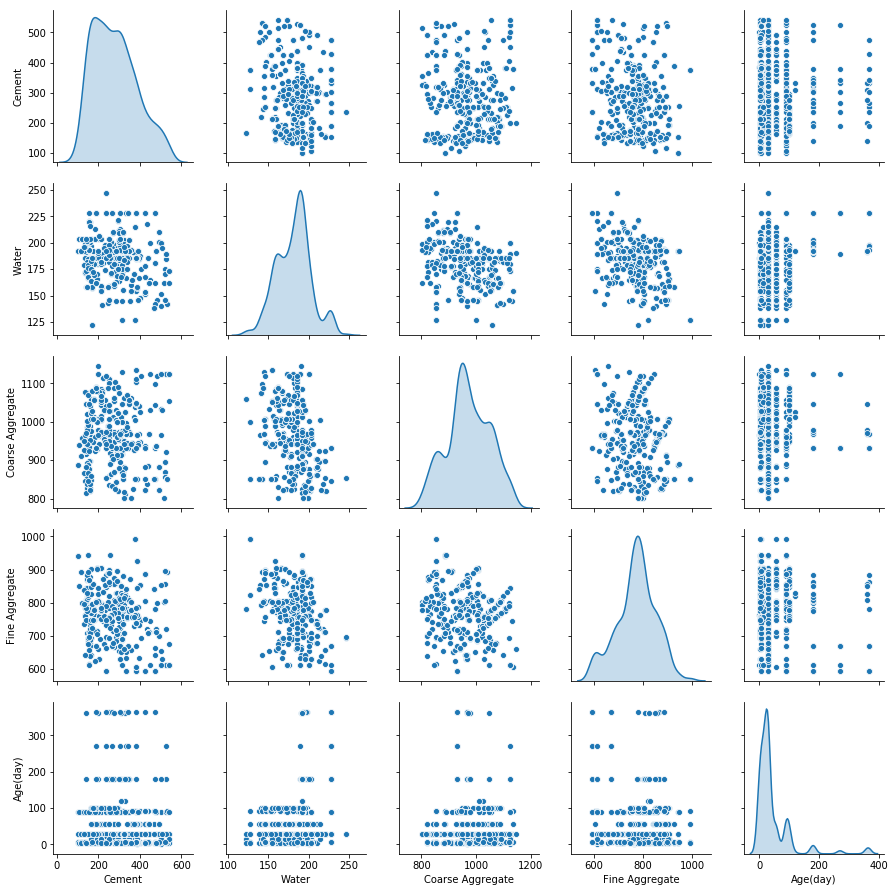

In [207]:

from __future__ import absolute_import, division, print_function

import pathlib

import pandas as pd
import seaborn as sns

import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os



column_names = ['Cement','Blast Furnace Slag','Fly Ash','Water','Superplasticizer','Coarse Aggregate','Fine Aggregate','Age(day)','Concrete compressive strength'
]

raw_dataset = pd.read_excel("Concrete_Data.xls",names=column_names,sheet_name=0,na_values = "?")

dataset = raw_dataset.copy()
dataset.tail()
dataset.isna().sum()
dataset = dataset.dropna()
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)



sns.pairplot(train_dataset[["Cement", "Water", "Coarse Aggregate", "Fine Aggregate", "Age(day)"]], diag_kind="kde")

train_stats = train_dataset.describe()
train_stats.pop("Concrete compressive strength")
train_stats = train_stats.transpose()



train_labels = train_dataset.pop('Concrete compressive strength')
test_labels = test_dataset.pop('Concrete compressive strength')


def norm(x):
  return (x - train_stats['mean']) / train_stats['std']


normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)


print(normed_train_data)

def build_model():
  model = keras.Sequential([
    layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation=tf.nn.relu, input_shape=[len(train_dataset.keys())],),
    layers.Dense(64,  kernel_regularizer=keras.regularizers.l2(0.001),activation=tf.nn.relu),
    layers.Dense(1)
  ])



  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()

model.summary()


# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('...............', end='')

EPOCHS = 1000



history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist.tail())


import matplotlib.pyplot as plt

def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Concrete compressive strength]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,15])
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Concrete compressive strength^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,80])

plot_history(history)



checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)




model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot(), cp_callback])







plot_history(history)


loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} Concrete compressive strength".format(mae))



test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Concrete compressive strength]')
plt.ylabel('Predictions [Concrete compressive strength]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])






error = test_predictions - test_labels
plt.hist(error, bins = 100)
plt.xlabel("Prediction Error [Concrete compressive strength]")
_ = plt.ylabel("Count")




from sklearn.metrics import r2_score
score=r2_score(test_labels, test_predictions, sample_weight=None, multioutput='uniform_average')


print("R^2 Score of the model is {:5.2f}".format(score))








model = build_model()
test_predictions = model.predict(normed_test_data).flatten()
score=r2_score(test_labels, test_predictions, sample_weight=None, multioutput='uniform_average')


print("R^2 Score of the model is {:5.2f}".format(score))

model.load_weights(checkpoint_path)
test_predictions = model.predict(normed_test_data).flatten()
score=r2_score(test_labels, test_predictions, sample_weight=None, multioutput='uniform_average')


print("R^2 Score of the model after picking up the Weight is {:5.2f}".format(score))



In [205]:


type(normed_test_data)


pandas.core.frame.DataFrame

In [206]:
normed_test_data


,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age(day)
11,1.401885,-0.285733,-0.871423,2.186387,-1.044893,-0.532438,-2.296728,3.608833
19,1.401885,-0.285733,-0.871423,2.186387,-1.044893,-0.532438,-2.296728,2.164387
23,0.947189,-0.844416,-0.871423,2.186387,-1.044893,-0.532438,-1.326680,5.133526
25,0.947189,0.272950,-0.871423,2.186387,-1.044893,-0.532438,-2.296728,3.608833
28,1.856581,-0.844416,-0.871423,2.186387,-1.044893,-0.532438,-2.296728,-0.612159
32,1.856581,-0.844416,-0.871423,2.186387,-1.044893,-0.532438,-2.296728,3.608833
36,0.492493,0.831633,-0.871423,2.186387,-1.044893,-0.532438,-2.296728,0.719941
41,-0.416899,1.948999,-0.871423,2.186387,-1.044893,-0.532438,-2.296728,5.133526
42,0.947189,-0.844416,-0.871423,2.186387,-1.044893,-0.532438,-1.326680,2.164387
43,1.401885,-0.285733,-0.871423,2.186387,-1.044893,-0.532438,-2.296728,0.719941
